In [7]:
import pandas as pd
import numpy as np

from funcs.ad import aggregate_pvalues, get_sigma_values

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns


def colorcode_rotation(st_rotp):
    """Define color code and symbol marker for rotation period.
    
    Parameters
    ----------
    st_rotp : float
        Rotation period in days.
    
    Returns
    -------
    color : str
        Color code.
    marker : str
        Symbol marker.
    """
    if st_rotp < 10.:
        color = "green"
        symbol = "o"

    elif (st_rotp >= 10.) & (st_rotp < 15.):
        color = "blue"
        symbol = "x"

    elif (st_rotp >= 15.):
        color = "black"
        symbol = "d"

    else:
        color = "lightgrey"
        symbol = "s"

    return color, symbol


def obstime(n, mission):
    if n > 50000:
        if mission == "TESS":
            return n / 3. / 60. / 24. # 20 sec cadence
        elif mission == "Kepler":
            return n / 60. / 24. # 1 min cadence
    else:
        if mission == "TESS":
            return n * 2. / 60. / 24. # 2 min cadence
        elif mission == "Kepler":
            return n / 60. / 24. # 1 min cadence
        else:
            raise ValueError(f"{n} data points for {mission} is not enough to calculate the observation time")

In [62]:
# read in AD test results
adtests = pd.read_csv("../results/multistar_adtest.csv")

# read in the table of known parameters from the NASA Exoplanet Archive and TESS
sps_w_ad = pd.read_csv("../results/params_of_star_planet_systems_with_AD_tests.csv")

# rename column tic_id to TIC
sps_w_ad.rename(columns={"tic_id": "TIC"}, inplace=True)

# read in non-transiting system table
sps_w_ad_rv = pd.read_csv("../data/2022_11_15_input_catalog_NONtransit_star_planet_systems.csv")

# concat the two tables
sps_w_ad = pd.concat([sps_w_ad, sps_w_ad_rv], axis=0)

# read in age and rotation period from the literature search
literature_params = pd.read_csv("../results/2022_09_stellar_params_with_coherence_times.csv")
literature_params.TIC = literature_params.TIC.astype(str)

# aggregate the p-values
mean_std = aggregate_pvalues(adtests, subsample="ED>1s", period="orbit")

# merge the AD test results with the stellar parameters
mean_std = mean_std.merge(literature_params, on=["TIC"], how="left")

# define the colors and symbols for the different rotation periods
mean_std["color"], mean_std["symbol"] = zip(*mean_std.st_rotp.apply(colorcode_rotation))

# add semi-major axis in AU to the table
g = lambda x: sps_w_ad[sps_w_ad.TIC.astype(str) == str(x)].pl_orbsmax.values[0]
mean_std["a_au"] = mean_std.TIC.apply(g)


In [63]:
# get the flare table
flares = pd.read_csv("../results/2022_07_flares_vetted.csv")

# calculate time covered by the observations,
# get orbital period from either Kepler or TESS, and
# calculate the number of orbits covered by the observations

# initialize empty lists
orbits_covered = []
orbpers = []
obstimes_d = []

# loop over all star-planet systems
for sys, row in mean_std.iterrows():
   
    # get total observing time per system
    sysvalues = flares[flares.TIC.astype(str) == str(row.TIC)]
    vals = sysvalues[["total_n_valid_data_points","mission"]].drop_duplicates()

    obstime_d = vals.apply(lambda x: obstime(x.total_n_valid_data_points, x.mission), axis=1).sum()

    # get orbital period
    sysvalues = sps_w_ad[sps_w_ad.TIC.astype(str) == str(row.TIC)]
    orbper = sysvalues.pl_orbper_kepler.values[0]
    if np.isnan(orbper):
        orbper = sysvalues.pl_orbper_tess.values[0]

    orbpers.append(orbper)
    obstimes_d.append(obstime_d)
    orbits_covered.append(obstime_d / orbper)

# add to dataframe
mean_std["orbits_covered"] = orbits_covered
mean_std["orbper_d"] = orbpers
mean_std["obstime_d"] = obstimes_d

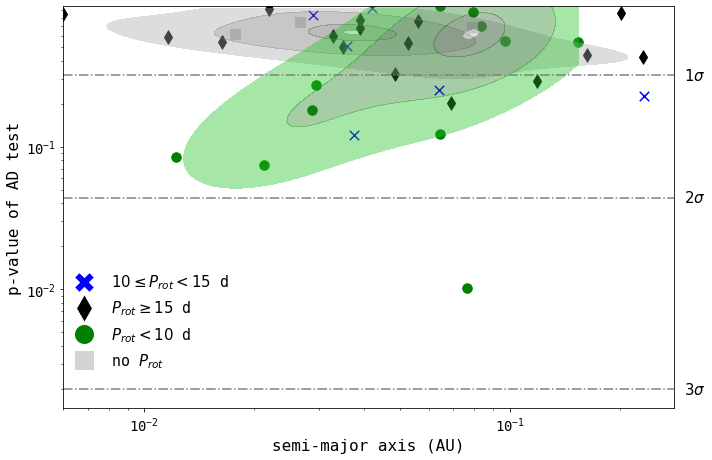

In [67]:
# ------------------------------------------------------------
# Plotting setup
# get reference sigma values
sigmas, sigma_labels = get_sigma_values()

# define legend elements
legend = [Line2D([0], [0], marker='X', color='w',
          markerfacecolor='blue', markersize=10),
          Line2D([0], [0], marker='d', color='w',
          markerfacecolor='black', markersize=10),
          Line2D([0], [0], marker='o', color='w', 
          markerfacecolor='green', markersize=10),    
          Line2D([0], [0], marker='s', color='w',
          markerfacecolor='lightgrey', markersize=10)]

# define legend labels
labels = [r"$10 \leq P_{rot} < 15$ d",
          r"$P_{rot} \geq 15$ d",
          r"$P_{rot} < 10$ d",
          r"no $P_{rot}$"]

# ------------------------------------------------------------

# P-VALUE VS. SEMI-MAJOR AXIS

# set up figure
fig, ax = plt.subplots(figsize=(10,6.5))

# plot the data
for color, group in mean_std.groupby("color"):
    plt.scatter(group["a_au"], group["mean"], marker=group["symbol"].iloc[0],     
        c=color, s=90., alpha=1.)
    if (color != "lightgrey") & (color != "blue"):
        sns.kdeplot(data=group, x="a_au", y="mean", fill=True,
                color = color, common_norm=True, alpha=.4, log_scale=True,
               cut=0., levels=[0.32, 0.68, 0.95, 0.997])
    

# log scale
plt.yscale("log")
plt.xscale("log")

# add sigma lines
for sigma, label in list(zip(sigmas, sigma_labels)):
    plt.axhline(sigma, color="grey", linestyle="-.")
    plt.text(.3, sigma, label, fontsize=15, color="k", verticalalignment="center")

# labels
plt.ylabel("p-value of AD test")
plt.xlabel("semi-major axis (AU)")

# legend
plt.legend(legend,labels,loc=(0,0.08), fontsize=15)

# save figure
plt.savefig("../results/plots/2022_11_22_adtests_vs_semimajor_axis_kde.png", dpi=300)

# ------------------------------------------------------------

Text(0, 0.5, 'orbital period [days]')

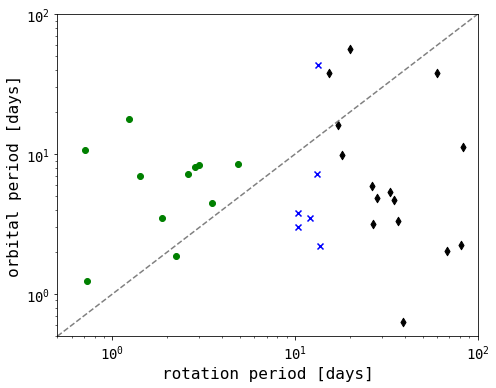

In [31]:
minper, maxper = 0.5, 100

# set up figure
fig, ax = plt.subplots(figsize=(7,5.5))

for sys, row in mean_std.iterrows():
    sysvalues = sps_w_ad[sps_w_ad.TIC.astype(str) == str(row.TIC)]
  
    orbper = sysvalues.pl_orbper_kepler.values[0]
    if np.isnan(orbper):
        orbper = sysvalues.pl_orbper_tess.values[0]
   
    plt.scatter([row.st_rotp], [orbper], marker=row["symbol"], color=row["color"])

plt.plot([minper,maxper], [minper,maxper], color="grey", linestyle="--")

plt.xscale("log")
plt.yscale("log")
plt.xlim(minper, maxper)
plt.ylim(minper, maxper)
plt.xlabel("rotation period [days]")
plt.ylabel("orbital period [days]")

    

Text(0, 0.5, 'flares per day of observations')

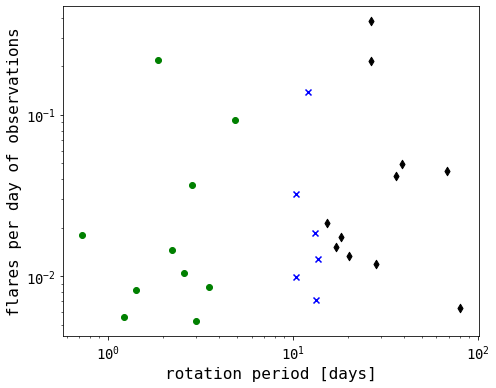

In [38]:
minper, maxper = 0.5, 100

# set up figure
fig, ax = plt.subplots(figsize=(7,5.5))

for sys, row in mean_std.iterrows():
   
    plt.scatter(row.st_rotp, row.number_of_flares/row.time_span_d,
                marker=row["symbol"], color=row["color"])


plt.xscale("log")
plt.yscale("log")
# plt.xlim(minper, maxper)
# plt.ylim(minper, maxper)
plt.xlabel("rotation period [days]")
plt.ylabel("flares per day of observations")

    

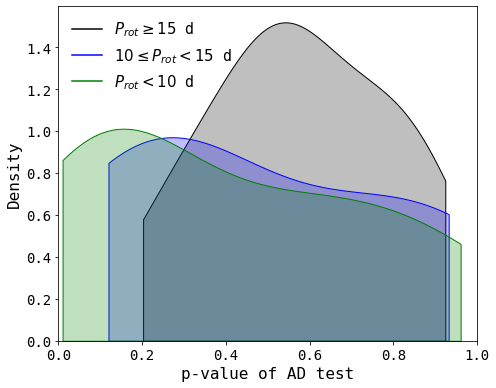

In [60]:
# define legend elements
legend = [Line2D([0], [0], marker='', color='black',
          markerfacecolor='black', markersize=10),
         Line2D([0], [0], marker='', color='blue',
          markerfacecolor='blue', markersize=10),
          Line2D([0], [0], marker='', color='green', 
          markerfacecolor='green', markersize=10), ]

# define legend labels
labels = [r"$P_{rot} \geq 15$ d",
          r"$10 \leq P_{rot} < 15$ d",
          r"$P_{rot} < 10$ d",]

# set up figure
fig, ax = plt.subplots(figsize=(7,5.5))
bins = np.logspace(-2.1,0,10)
for color, group in mean_std.groupby("color"):
    if color != "lightgrey":
        # plt.hist(group["mean"], linewidth=4,
        #       color=color, bins=bins, alpha=0.5, label=color)
        sns.kdeplot(data=group, x="mean", fill=True,color=color, cut=0)
    

# plt.xscale("log")
# plt.yscale("log")
plt.xlim(0,1)
# plt.ylim(minper, maxper)
#plt.xlabel("semi-major axis [AU]")
plt.xlabel("p-value of AD test")

# legeng
plt.legend(legend,labels,loc=2, fontsize=15)

# save figure
plt.savefig("../results/plots/2022_11_22_adtests_kde_vs_rotation.png", dpi=300)

      total_n_valid_data_points mission
5584                      16994  Kepler
5585                      44875  Kepler
5598                      51069  Kepler
5623                      35655  Kepler
5658                      19611    TESS
5661                      18322    TESS
5663                      16994    TESS
     total_n_valid_data_points mission
942                      43543  Kepler
943                       7621  Kepler
944                      52752  Kepler
945                      44875  Kepler
946                      51069  Kepler
947                      34810  Kepler
948                      46804  Kepler
949                      42289  Kepler
950                      39121  Kepler
951                      34037  Kepler
952                      32946  Kepler
953                       6151  Kepler
954                      44145  Kepler
955                      49956  Kepler
956                      46462  Kepler
957                      39984  Kepler
960              

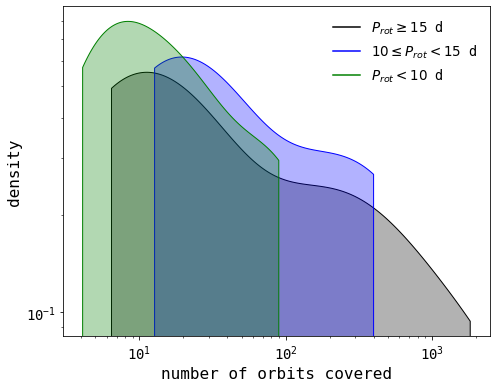

In [58]:


minper, maxper = 0.5, 100


# set up figure
fig, ax = plt.subplots(figsize=(7,5.5))


for color, group in mean_std.groupby("color"):
    # print(rotp, np.mean(group.orbits_covered))
    print(color)
    if color != "lightgrey":
        sns.kdeplot(data=group, x="orbits_covered", fill=True,
                color = color, common_norm=True, alpha=.3, log_scale=True, cut=0
               )

plt.xscale("log")
plt.yscale("log")
# plt.xlim(minper, maxper)
# plt.ylim(minper, maxper)
plt.ylabel("density")
plt.xlabel("number of orbits covered")

# legeng
plt.legend(legend,labels,loc=1, fontsize=13.5)
    

In [59]:
mean_std[["orbits_covered", "orbper","ID"]]

,orbits_covered,orbper,ID
0,24.917556,7.202837,Kepler-1627
1,8.079958,56.056054,Kepler-705
2,6.655121,16.080661,Kepler-636
3,21.195127,3.504704,Kepler-1558
4,16.939762,4.485584,Kepler-1646
5,399.308092,2.211099,Kepler-55
6,6.307323,6.959503,HIP 67522
7,77.042215,17.855182,KOI-12
8,89.769262,1.239149,TOI-540
9,3.944426,11.949000,GJ 3082


In [32]:
mean_std.columns.values

array(['TIC', 'number_of_flares', 'mean', 'std', 'ID', 'st_rotp',
       'st_rotp_err', 'source', 'note', 'age', 'age_uperr', 'age_lowerr',
       'agesource', 'abs_tstart_min', 'abs_tstart_max', 'time_span_d',
       'coherence_timescale_rotation_d', 'coherence_ratio', 'color',
       'symbol'], dtype=object)

# Compare to fake p-value calculations

In [ ]:
# read in AD test results
adtests = pd.read_csv("../results/multistar_adtest.csv")

# get different modes
modes = adtests["period"].unique()

# read in the table of known parameters from the NASA Exoplanet Archive and TESS
sps_w_ad = pd.read_csv("../results/params_of_star_planet_systems_with_AD_tests.csv")

# read in age and rotation period from the literature search
literature_params = pd.read_csv("../results/2022_09_stellar_params_with_coherence_times.csv")
literature_params.TIC = literature_params.TIC.astype(str)

res = pd.DataFrame()
print(res.shape)
# aggregate the p-values
for mode in modes:
    
    mean_std = aggregate_pvalues(adtests, subsample="ED>1s", period=mode)
    print(mode)

    mean_std = mean_std[["TIC","mean"]]
    
    if res.shape[0] == 0:
        res = mean_std.set_index("TIC")
    else:
        # join the the table to res as a new column
        res = res.merge(mean_std, on="TIC", how="left")

    res = res.rename(columns={"mean": f"mean_{mode}"})

# merge the AD test results with the stellar parameters
res = res.merge(literature_params, on=["TIC"], how="left")


In [ ]:
res.columns

In [ ]:
plt.figure(figsize=(9,6.5))

for mode in modes:
    if mode == "orbit":
        o = 10
        histtype = "bar"
    else:
        o = 1
        histtype="step"
    plt.hist(res[f"mean_{mode}"], bins=np.logspace(-3,0,15), 
              label=mode.replace("_"," "), linewidth=3,zorder=o,alpha=.5, histtype=histtype)

plt.xscale("log")
plt.legend(loc=2)
plt.xlabel("p-value of AD test")
plt.ylabel("number of stars")